### Importar base de dados e instalar framework de recomendação

### Importar bibliotecas

In [5]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar.gz


In [13]:
import sys
!{sys.executable} -m pip install caserecommender

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np

### Explorar Dados

In [2]:
movies = pd.read_csv('./dataset/movies_sample.csv')
movies.tail()

,movieId,title,genres
428,129857,Bright Days Ahead (2013),Drama|Romance
429,130344,Coast of Death (2013),Children|Documentary|Drama
430,130408,A Rumor Of War (1980),(no genres listed)
431,130510,Berserk: The Golden Age Arc 3 - Descent (2013),Action|Animation|Fantasy
432,131239,Three Quarter Moon (2011),Comedy|Drama


In [4]:
ratings = pd.read_csv('./dataset/ratings_sample.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,11,7481,5.0,1230788624
1,11,1046,4.5,1251144145
2,11,616,4.0,1230782542
3,11,3535,2.0,1230784884
4,11,5669,5.0,1230853788


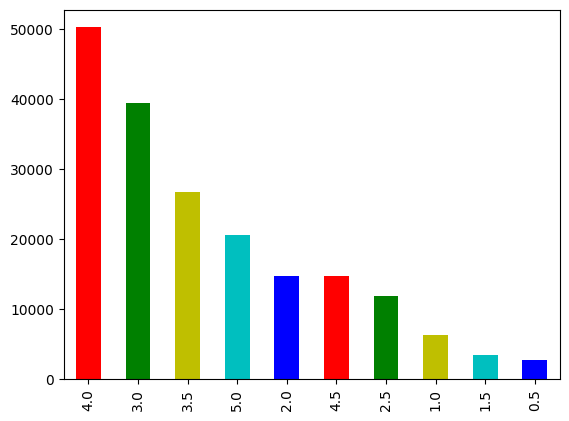

In [5]:
import matplotlib.pyplot as plt
ratings.rating.value_counts().plot(kind='bar', color=['r', 'g', 'y', 'c', 'b']);
plt.show()

In [6]:
df = ratings[['userId', 'movieId', 'rating']]
df.tail()

,userId,movieId,rating
190616,138493,288,5.0
190617,138493,1748,5.0
190618,138493,616,4.0
190619,138493,1597,4.5
190620,138493,7371,5.0


In [7]:
df = df.merge(movies[['movieId', 'title']])
df.head()

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,359,7481,4.0,Enemy Mine (1985)
2,422,7481,3.0,Enemy Mine (1985)
3,424,7481,3.0,Enemy Mine (1985)
4,744,7481,3.0,Enemy Mine (1985)


### Números de usuários e número de itens

In [8]:
print(
"""
Número de usuários: {}
Número de itens: {}
Número de interações: {}
""".format(
    df.userId.nunique(),
    df.movieId.nunique(),
    df.shape[0]
)
)


Número de usuários: 11090
Número de itens: 417
Número de interações: 190621



### Mapeamento em idx

In [9]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

In [10]:
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
df.head()

,userId,movieId,rating,title
0,0,0,5.0,Enemy Mine (1985)
1,1,0,4.0,Enemy Mine (1985)
2,2,0,3.0,Enemy Mine (1985)
3,3,0,3.0,Enemy Mine (1985)
4,4,0,3.0,Enemy Mine (1985)


In [11]:
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [12]:
print(len(map_title))
print(map_title[100])

417
Send Me No Flowers (1964)


In [13]:
# qtd interações dos usuários
df.groupby('userId').count()

,movieId,rating,title
userId,,,
0,13,13,13
1,25,25,25
2,14,14,14
3,25,25,25
4,11,11,11
...,...,...,...
11085,11,11,11
11086,10,10,10
11087,25,25,25


### Divisão do dataset

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.txt', index=False, header=False, sep='\t')
test.to_csv('test.txt', index=False, header=False, sep='\t')

In [15]:
! ls -l

total 150656
-rw-r--r--@ 1 manzato  staff     19168 Aug 16 17:10 Aula01_Exemplos.ipynb
-rw-r--r--@ 1 manzato  staff    101135 Aug 16 17:18 Aula01_Exercicios.ipynb
-rw-r--r--@ 1 manzato  staff    107522 Aug 16 10:22 Aula01_Exercicios_Respostas.ipynb
drwxr-xr-x  9 manzato  staff       288 Mar 17 10:51 dataset
-rw-r--r--  1 manzato  staff  65019041 Aug  2 14:47 ml-20m-compact.tar.gz
-rw-r--r--  1 manzato  staff    644050 Aug 16 09:56 out_mp_pred.txt
-rw-r--r--  1 manzato  staff   2188701 Aug  2 16:50 out_mp_pred_binary.txt
-rw-r--r--  1 manzato  staff    644050 Aug  2 16:58 rp_iknn.txt
-rw-r--r--  1 manzato  staff   1490769 Aug 16 17:19 test.txt
-rw-r--r--  1 manzato  staff   5951786 Aug 16 17:19 train.txt


In [16]:
print('No. items: ' + str(train['movieId'].nunique()))
print('No. users: ' + str(train['userId'].nunique()))

No. items: 403
No. users: 11090


### Recomendadores

## Prever notas

In [18]:
from caserec.recommenders.rating_prediction.most_popular import MostPopular

In [19]:
MostPopular('train.txt', 'test.txt', 'out_mp_pred.txt').compute()

[Case Recommender: Rating Prediction > Most Popular]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

prediction_time:: 22.501840 sec


Eval:: MAE: 0.703266 RMSE: 0.910252 


In [22]:
df_pred = pd.read_csv('out_mp_pred.txt', sep='\t', names=['userId', 'movieId', 'pred'])
df_pred.head(10)

,userId,movieId,pred
0,0,0,3.443980
1,0,5,3.333857
2,1,6,3.573171
3,1,106,3.290084
4,1,21,3.211811
5,1,30,3.651042
6,1,12,4.176005
7,2,30,3.651042
8,2,42,3.513158
9,2,69,2.475379


In [23]:
test[test.userId == 1]

,userId,movieId,rating,title
17476,1,6,4.5,Apocalypto (2006)
172435,1,106,2.5,Shopgirl (2005)
75352,1,21,2.5,Conspiracy Theory (1997)
103814,1,30,3.5,Collateral (2004)
31545,1,12,4.0,Star Wars: Episode V - The Empire Strikes Back...


In [24]:
df_pred = df_pred.merge(test)

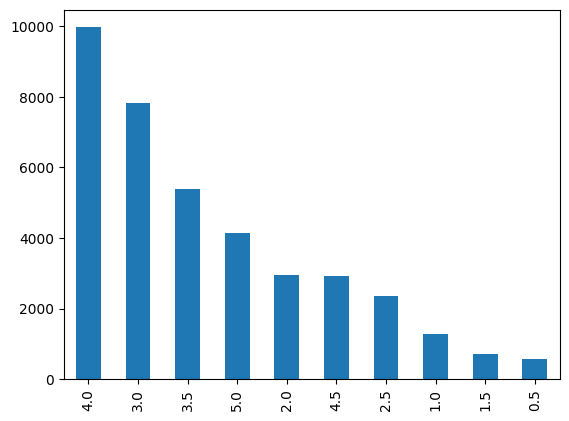

In [25]:
df_pred.rating.value_counts().plot(kind='bar')
plt.show()

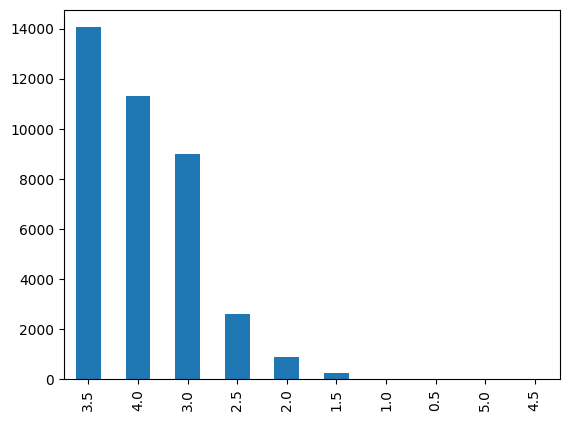

In [26]:
df_pred['pred'] = round(df_pred['pred']*2)/2
df_pred.pred.value_counts().plot(kind='bar');
plt.show()

### Top N

In [27]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular as MPR

In [28]:
MPR('train.txt', 'test.txt', 'out_mp_pred_binary.txt', as_binary=True).compute()

[Case Recommender: Item Recommendation > Most Popular]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

prediction_time:: 1.348061 sec


Eval:: PREC@1: 0.390555 PREC@3: 0.253801 PREC@5: 0.21312 PREC@10: 0.167009 RECALL@1: 0.123509 RECALL@3: 0.227113 RECALL@5: 0.311363 RECALL@10: 0.481113 MAP@1: 0.390555 MAP@3: 0.458313 MAP@5: 0.463942 MAP@10: 0.437594 NDCG@1: 0.390555 NDCG@3: 0.523907 NDCG@5: 0.549345 NDCG@10: 0.552196 


In [29]:
ranking = pd.read_csv('out_mp_pred_binary.txt', sep='\t', names=['userId', 'movieId', 'score'])
ranking['title'] = ranking.movieId.map(map_title)
ranking.head(15)

,userId,movieId,score,title
0,0,19,6379.0,Reservoir Dogs (1992)
1,0,22,4562.0,Natural Born Killers (1994)
2,0,17,4461.0,Chasing Amy (1997)
3,0,18,4279.0,Life Is Beautiful (La Vita è bella) (1997)
4,0,33,3860.0,North by Northwest (1959)
5,0,21,3666.0,Conspiracy Theory (1997)
6,0,5,3503.0,"I, Robot (2004)"
7,0,20,3471.0,While You Were Sleeping (1995)
8,0,23,3466.0,Crimson Tide (1995)
9,0,28,3344.0,My Best Friend's Wedding (1997)


### Item KNN

In [76]:
from caserec.recommenders.rating_prediction.itemknn import ItemKNN

ItemKNN('train.txt', 'test.txt', 'rp_iknn.txt', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

training_time:: 4.184332 sec
prediction_time:: 2.534259 sec
Eval:: MAE: 0.665964 RMSE: 0.876739 


**Exercício 01:**

a) Encontrar o id do usuário que avaliou mais filmes na base. Informe o id externo (da base dados) e o interno (usado pelo recomendador)

In [1]:
# TODO

b) Encontrar os 5 primeiros usuários que têm maior propensão a dar notas baixas aos filmes (use a média de ratings para isso).

In [2]:
# TODO

c) Encontrar os 5 filmes pior avaliados pelos usuários.

In [3]:
# TODO

**Exercício 02:** Na aula vimos uma abordagem de recomendação não personalizada que utiliza a quantidade de interações dos itens para recomendar filmes mais populares aos usuários. Quando há feedback explícito, entretanto, a mesma abordagem "Most Popular" pode fazer uso da média das notas disponíveis, ou seja, recomendam-se os N filmes mais bem avaliados a cada usuário. Desse modo, calcule a recomendação de 5 filmes para um usuário qualquer da base considerando essa estratégia não personalizada. Utilize a base toda como conjunto de treinamento.

In [23]:
# TODO

**Exercício 03:** Com base no código disponível no notebook "Aula01_Exemplos.ipynb", implemente uma função que retorna os k filmes mais similares a um outro qualquer passado como parâmetro. 

In [15]:
# TODO